# LSTM em Ve√≠culos Combust√£o e El√©trico

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

SEED = 42

import warnings
warnings.filterwarnings("ignore")

## Datasets

### Combust√£o

In [5]:
df_comb = pd.read_csv("./data/combustion_clean.csv", sep=",")
df_comb.head()

Unnamed: 0  Speed (OBD)(km/h)  Absolute Throttle Position B(%)  Torque(Nm)  \
0          30               26.0                        14.509804   13.938316   
1          31               27.0                        16.078432    7.000541   
2          32               27.0                        16.862745    7.000541   
3          33               29.0                        16.862745   13.678993   
4          34               31.0                        17.254902   14.091927   

   CO2_emission_g_per_km  
0             150.638715  
1             145.353899  
2             145.353899  
3             172.692135  
4             169.936145

In [6]:
n = len(df_comb)
n

2831

In [7]:
X_comb = df_comb[['Speed (OBD)(km/h)', 'Absolute Throttle Position B(%)', 'Torque(Nm)']].values
y_comb = df_comb['CO2_emission_g_per_km'].values

### El√©trico

In [8]:
df_elet = pd.read_csv("./data/electric_clean.csv", sep=",")
df_elet.head()

Unnamed: 0  Velocity [km/h]  Throttle [%]  Motor Torque [Nm]  \
0          69             3.47         20.26               6.38   
1          87             5.80         22.40              19.86   
2          88             5.88         22.40              16.76   
3          89             5.94         22.73              14.76   
4          90             6.00         22.90              11.24   

   CO2_emission_g_per_km  
0              14.977837  
1              14.693897  
2              13.213593  
3              11.965069  
4              11.093950

In [9]:
len(df_elet)

197493

In [10]:
# Ele pega um sample do dataset el√©trico para os dois terem o mesmo n√∫mero de registros. 
# Ele faz isso pq ele vai juntar os dois datasets lateralmente
df_elet_sample = df_elet.sample(n=len(df_comb), random_state=SEED)
X_elet = df_elet_sample[['Velocity [km/h]', 'Throttle [%]',	'Motor Torque [Nm]']].values
y_elet = df_elet_sample['CO2_emission_g_per_km'].values

### Juntando Lateralmente

In [11]:
# Juntando lateralmente
X = np.concatenate((X_comb, X_elet), axis=1)
X.shape

(2831, 6)

In [12]:
# Juntando verticalmente
# Tem um problema aqui. Ele concatena na horizontal as entradas, mas os r√≥tulos na vertical.
y = np.concatenate((y_comb, y_elet), axis=0)
y.shape

(5662,)

In [13]:
y.reshape(-1, 1).shape

(5662, 1)

## Normaliza√ß√£o

In [14]:
# Ele escolheu a normaliza√ß√£o min-max, mas poderia ter sido outra.
# Tem que testar os resultados com e sem essa normaliza√ß√£o. Assim como com outras normaliza√ß√µes.
# Eu tenho um notebook com os normalizadores j√°
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

## Treinamento Dos Modelos

In [61]:
def LSTM_model(X_train, X_test, y_train, y_test, epochs=10):
    # Reshape
    # X_train tem inicialmente 2264 linhas e 3 colunas
    # Depois do reshape, ela tem 2264 linhas, 1 coluna e 3 profundidades
    # Essa 1 coluna era para ser o tamanho da janela do LSTM.
    # No caso, ele est√° usando a janela de 1, n√£o tem janela.
    # Para aumentar a janela, n√£o basta apenas mexer nesse 1, tem que fazer um for e ir agrupando de tantos em tantos
    # Exemplo: https://www.geeksforgeeks.org/long-short-term-memory-lstm-rnn-in-tensorflow/ no step 3
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Arquitetura do modelo LSTM - (Rede neural que leva em considera√ß√£o uma janela de tempo)
    # Poderia usar uma arquitetura diferente. Eu vi um exemplo que usa LSTM, dropout, lstm, dropout e dense.
    model = tf.keras.Sequential(
        [
            # Input layer n√£o est√° descrito aqui. Est√° impl√≠cito
            tf.keras.layers.LSTM(32, activation='tanh', input_shape=(1, X_train.shape[2])), # Layer que √© o LSTM
            tf.keras.layers.Dense(32, activation='relu'), # Hidden layer 
            tf.keras.layers.Dense(1) # Output layer com um neur√¥nio para a regress√£o
        ]
    )

    # Compilando
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Treinando
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=16)

    # Gr√°fico do treinamento
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('√âpocas')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid()

    # Evaluation
    loss, mae = model.evaluate(X_test, y_test)
    print(f"MAE: {mae:.8f}, Loss: {loss:.8f}")

    return model

### Combust√£o

In [16]:
# Ele faz algo meio surreal, ainda n√£o sei se tem uma l√≥gica mais pra frente
# Ele est√° trabalhando com 2 datasets, um de combust√£o e outro el√©trico
# Cada um deles tem uma parte X de entradas e uma y do r√≥tulo.
# Ele junta lateralmente as duas partes X, sendo as colunas 0, 1 e 2 (:3) equilvalente as colunas de combust√£o
# As demais colunas a partir da terceira (3:) s√£o as do carro el√©trico

# Ao mesmo tempo, ele pega o menor dataset e faz um sample do outro para os dois ficarem do mesmo tamanho
# Em seguida ele concatena verticalmente. Ent√£o da linha 0 at√© o tamanho (n) √© o de combust√£o.
# De n at√© o final √© o de el√©trico.

# Para que ele embola tudo eu ainda n√£o sei.
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_scaled[:, :3], y_scaled[:n, 0], test_size=0.2, random_state=SEED)

I0000 00:00:1741877300.673369   37136 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6245 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/10


I0000 00:00:1741877302.182288   37485 cuda_dnn.cc:529] Loaded cuDNN version 90300


142/142 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 3ms/step - loss: 0.1473 - mae: 0.3158 - val_loss: 0.0216 - val_mae: 0.1028
Epoch 2/10
142/142 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 0.0181 - mae: 0.0946 - val_loss: 0.0089 - val_mae: 0.0677
Epoch 3/10
142/142 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0091 - mae: 0.0634 - val_loss: 0.0072 - val_mae: 0.0553
Epoch 4/10
142/142 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 0.0071 - mae: 0.0551 - val_loss: 0.0065 - val_mae: 0.0535
Epoch 5/10
142/142 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0073 - mae: 0.0565 - val_loss: 0.0064 - val_mae: 0.0564
Epoch 6/10
142/142 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 0.0068 - mae: 0.0549 - val_loss: 0.0058 - val_mae: 0.0508
Epoch 7/10
142/142 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

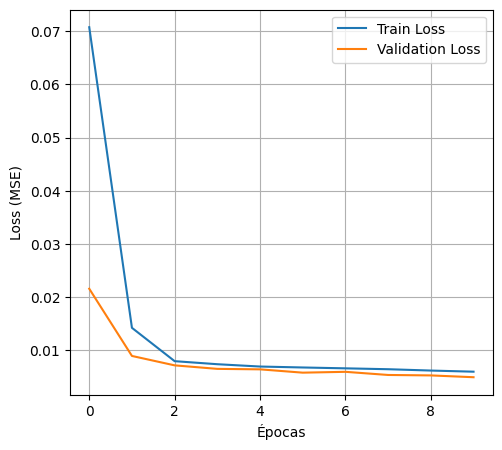

In [17]:
model_LSTM_comb = LSTM_model(X_train_comb, X_test_comb, y_train_comb, y_test_comb)

In [18]:
model_LSTM_comb.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm (LSTM)                     ‚îÇ (None, 32)             ‚îÇ         4,608 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 32)             ‚îÇ         1,056 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 17,093 (66.77 KB)

 Trainable params: 5,697 (22.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,396 (44.52 KB)

### El√©trico

In [43]:
# Para entender como ele passou os datasets, olhar os coment√°rios na parte de combust√£o
X_train_elet, X_test_elet, y_train_elet, y_test_elet = train_test_split(X_scaled[:, 3:], y_scaled[n:, 0], test_size=0.2, random_state=SEED)

In [59]:
X_train_elet.reshape((X_train_elet.shape[0], 1, X_train_elet.shape[1]))[0][0]

array([0.38370544, 0.48418679, 0.16346066])

Epoch 1/10
142/142 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - loss: 5.3585e-05 - mae: 0.0049 - val_loss: 1.2459e-05 - val_mae: 0.0021
Epoch 2/10
142/142 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 1.8997e-05 - mae: 0.0028 - val_loss: 1.2641e-05 - val_mae: 0.0023
Epoch 3/10
142/142 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 2.0338e-05 - mae: 0.0027 - val_loss: 1.1907e-05 - val_mae: 0.0020
Epoch 4/10
142/142 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 1.9271e-05 - mae: 0.0027 - val_loss: 1.2614e-05 - val_mae: 0.0022
Epoch 5/10
142/142 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 2.4859e-05 - mae: 0.0030 - val_loss: 1.1848e-05 - val_mae: 0.0019
Epoch 6/10
142/142 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - loss: 2.0549e-05 - mae: 0.0028 - val_loss: 1.1926e-05 - val_mae: 0.0020
Epoc

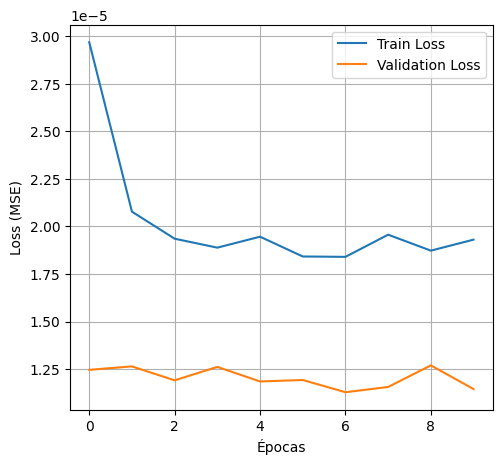

In [20]:
model_LSTM_elet = LSTM_model(X_train_elet, X_test_elet, y_train_elet, y_test_elet)

In [21]:
model_LSTM_elet.summary()

Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 32)             ‚îÇ         4,608 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 32)             ‚îÇ         1,056 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 17,093 (66.77 KB)

 Trainable params: 5,697 (22.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,396 (44.52 KB)

## Avalia√ß√£o

In [22]:
def plot_error_histogram(y_pred, y_test):
    # Erro √© o predito menos o real
    error = y_pred - y_test

    # Estat√≠sticas do erro
    mean_error = np.mean(error)
    std_error = np.std(error)
    min_error = np.min(error)
    max_error = np.max(error)

    # Histograma
    plt.hist(error, bins=30, color='blue', alpha=0.7, edgecolor='black')

    # Linhas de refer√™ncia
    plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label=f"M√©dia: {mean_error:.4f}")
    plt.axvline(mean_error + 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'+2œÉ: {(mean_error + 2*std_error):.4f}')
    plt.axvline(mean_error - 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'-2œÉ: {(mean_error - 2*std_error):.4f}')
    plt.axvline(min_error, color='purple', linestyle='dashed', linewidth=2, label=f'M√≠nimo: {min_error:.4f}')
    plt.axvline(max_error, color='orange', linestyle='dashed', linewidth=2, label=f'M√°ximo: {max_error:.4f}')

    # Extras
    plt.xlabel("Erro (y_pred - y_real)")
    plt.ylabel("Frequ√™ncia")
    plt.legend()
    plt.grid(True)

    plt.show()

### Combust√£o

18/18 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step 


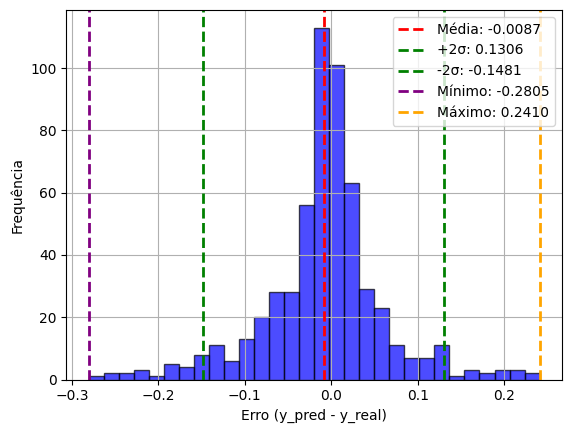

In [26]:
prediction_comb = model_LSTM_comb.predict(X_test_comb.reshape((X_test_comb.shape[0], 1, X_test_comb.shape[1])))
y_pred_comb = prediction_comb.reshape(1,-1)[0]

plot_error_histogram(y_pred_comb, y_test_comb)

### El√©trico

18/18 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step 


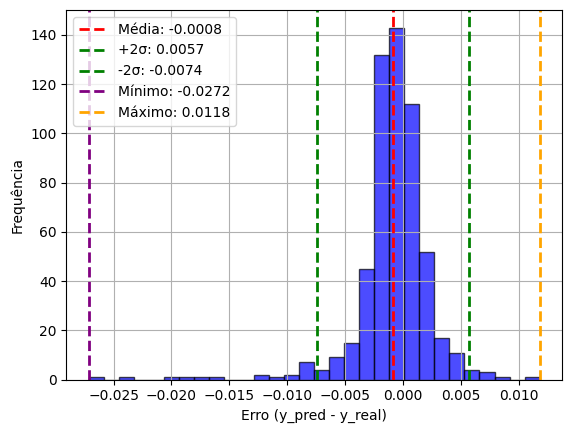

In [29]:
prediction_elet = model_LSTM_elet.predict(X_test_elet.reshape((X_test_comb.shape[0], 1, X_test_elet.shape[1])))
y_pred_elet = prediction_elet.reshape(1,-1)[0]

plot_error_histogram(y_pred_elet, y_test_elet)

## Entradas a Combust√£o no Modelo do el√©trico (Loucura)

In [31]:
X_test_comb.shape

(567, 3)

In [32]:
X_test_comb = X_test_comb.reshape((X_test_comb.shape[0], 1, X_test_comb.shape[1]))
X_test_comb.shape

(567, 1, 3)

In [33]:
# Pq ele est√° usando os dados de combust√£o no modelo el√©trico???
y_pred_elet = model_LSTM_elet.predict(X_test_comb)

18/18 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step 


In [35]:
# Agora ele uso os dados de combust√£o com o modelo certo
y_pred_comb = model_LSTM_comb.predict(X_test_comb)

18/18 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step 


### Desnormalizando

In [36]:
# Est√° concatenando na vertical os dois Ys. 
# Y de teste da combust√£o
# Y previsto do el√©trico
y_concat = np.concatenate(
    (y_test_comb.reshape(len(y_test_comb), 1), y_pred_elet), 
    axis=0
)

result_pred_inv = scaler_y.inverse_transform(y_concat)

In [37]:
# Novamente ele est√° fazendo aquela coisa de concatenar os datasets que n√£o tem nada haver para aplicar uma vez s√≥ alguma fun√ß√£o
# Isso n√£o melhora em nada, apenas dificulta a leitura
y_pred_comb_inv = result_pred_inv[:len(y_test_comb)]
y_pred_elet_inv = result_pred_inv[len(y_test_comb):]

### Comparativo

In [40]:
# Ele escreve uma condi√ß√£o aqui que vai utilizar em todas as f√≥rmulas a seguir.
# Nessa condi√ß√£o ele est√° pegando apenas os casos que a predi√ß√£o foi maior que zero.
# Na real, n√£o podemos ter uma emiss√£o negativa de CO2
valid_idx = (y_pred_comb_inv > 0) & (y_pred_elet_inv > 0)

# Predito da combust√£o menos o predito do el√©trico. Isso seria a predi√ß√£o da redu√ß√£o de emiss√µes
reducao_absoluta = y_pred_comb_inv[valid_idx] - y_pred_elet_inv[valid_idx]

# Calculando o percentual de redu√ß√£o. (Regra de 3)
reducao_percentual = (reducao_absoluta / y_pred_comb_inv[valid_idx]) * 100

# Estat√≠sticas combust√£o
media_comb = np.mean(y_pred_comb_inv[valid_idx])
mediana_comb = np.median(y_pred_comb_inv[valid_idx])
desvio_comb = np.std(y_pred_comb_inv[valid_idx])
variancia_comb = np.var(y_pred_comb_inv[valid_idx])
min_comb = np.min(y_pred_comb_inv[valid_idx])
max_comb = np.max(y_pred_comb_inv[valid_idx])
cv_comb = desvio_comb / media_comb * 100  # Coeficiente de varia√ß√£o (%)

# Estat√≠sticas el√©trico
media_elet = np.mean(y_pred_elet_inv[valid_idx])
mediana_elet = np.median(y_pred_elet_inv[valid_idx])
desvio_elet = np.std(y_pred_elet_inv[valid_idx])
variancia_elet = np.var(y_pred_elet_inv[valid_idx])
min_elet = np.min(y_pred_elet_inv[valid_idx])
max_elet = np.max(y_pred_elet_inv[valid_idx])
cv_elet = desvio_elet / media_elet * 100  # Coeficiente de varia√ß√£o (%)

# Estat√≠sticas para redu√ß√£o absoluta
media_reducao_absoluta = np.mean(reducao_absoluta)
mediana_reducao_absoluta = np.median(reducao_absoluta)
desvio_reducao_absoluta = np.std(reducao_absoluta)
variancia_reducao_absoluta = np.var(reducao_absoluta)
min_reducao_absoluta = np.min(reducao_absoluta)
max_reducao_absoluta = np.max(reducao_absoluta)
cv_reducao_absoluta = desvio_reducao_absoluta / media_reducao_absoluta * 100  

# Estat√≠sticas para redu√ß√£o percentual
media_reducao_percentual = abs(np.mean(reducao_percentual))
mediana_reducao_percentual = abs(np.median(reducao_percentual))
desvio_reducao_percentual = np.std(reducao_percentual)
variancia_reducao_percentual = np.var(reducao_percentual)
min_reducao_percentual = np.min(reducao_percentual)
max_reducao_percentual = np.max(reducao_percentual)
cv_reducao_percentual = desvio_reducao_percentual / media_reducao_percentual * 100

In [41]:
# Exibir os resultados m√©dios
print(f"üöó Emiss√£o m√©dia (Combust√£o): {media_comb:.2f} g CO2/km")
print(f"   - Mediana: {mediana_comb:.2f} g CO2/km")
print(f"   - Desvio padr√£o: {desvio_comb:.2f}")
print(f"   - Vari√¢ncia: {variancia_comb:.2f}")
print(f"   - Min: {min_comb:.2f} | Max: {max_comb:.2f}\n")


print(f"‚ö° Emiss√£o m√©dia (El√©trico): {media_elet:.2f} g CO2/km")
print(f"   - Mediana: {mediana_elet:.2f} g CO2/km")
print(f"   - Desvio padr√£o: {desvio_elet:.2f}")
print(f"   - Vari√¢ncia: {variancia_elet:.2f}")
print(f"   - Min: {min_elet:.2f} | Max: {max_elet:.2f}\n")


print(f"üîΩ Redu√ß√£o m√©dia absoluta: {media_reducao_absoluta:.2f} g CO2/km")
print(f"   - Mediana: {mediana_reducao_absoluta:.2f} g CO2/km")
print(f"   - Desvio padr√£o: {desvio_reducao_absoluta:.2f}")
print(f"   - Vari√¢ncia: {variancia_reducao_absoluta:.2f}")
print(f"   - Min: {min_reducao_absoluta:.2f} | Max: {max_reducao_absoluta:.2f}\n")


print(f"üìâ Redu√ß√£o m√©dia percentual: {media_reducao_percentual:.2f}%")
print(f"   - Mediana: {mediana_reducao_percentual:.2f}%")
print(f"   - Desvio padr√£o: {desvio_reducao_percentual:.2f}")
print(f"   - Vari√¢ncia: {variancia_reducao_percentual:.2f}")
print(f"   - Min: {min_reducao_percentual:.2f}% | Max: {max_reducao_percentual:.2f}%\n")

üöó Emiss√£o m√©dia (Combust√£o): 141.94 g CO2/km
   - Mediana: 132.42 g CO2/km
   - Desvio padr√£o: 36.56
   - Vari√¢ncia: 1336.47
   - Min: 71.74 | Max: 260.38

‚ö° Emiss√£o m√©dia (El√©trico): 6.87 g CO2/km
   - Mediana: 7.17 g CO2/km
   - Desvio padr√£o: 2.33
   - Vari√¢ncia: 5.44
   - Min: 1.55 | Max: 14.43

üîΩ Redu√ß√£o m√©dia absoluta: 135.07 g CO2/km
   - Mediana: 125.43 g CO2/km
   - Desvio padr√£o: 36.42
   - Vari√¢ncia: 1326.55
   - Min: 63.79 | Max: 256.34

üìâ Redu√ß√£o m√©dia percentual: 94.91%
   - Mediana: 94.71%
   - Desvio padr√£o: 1.96
   - Vari√¢ncia: 3.83
   - Min: 87.61% | Max: 99.25%



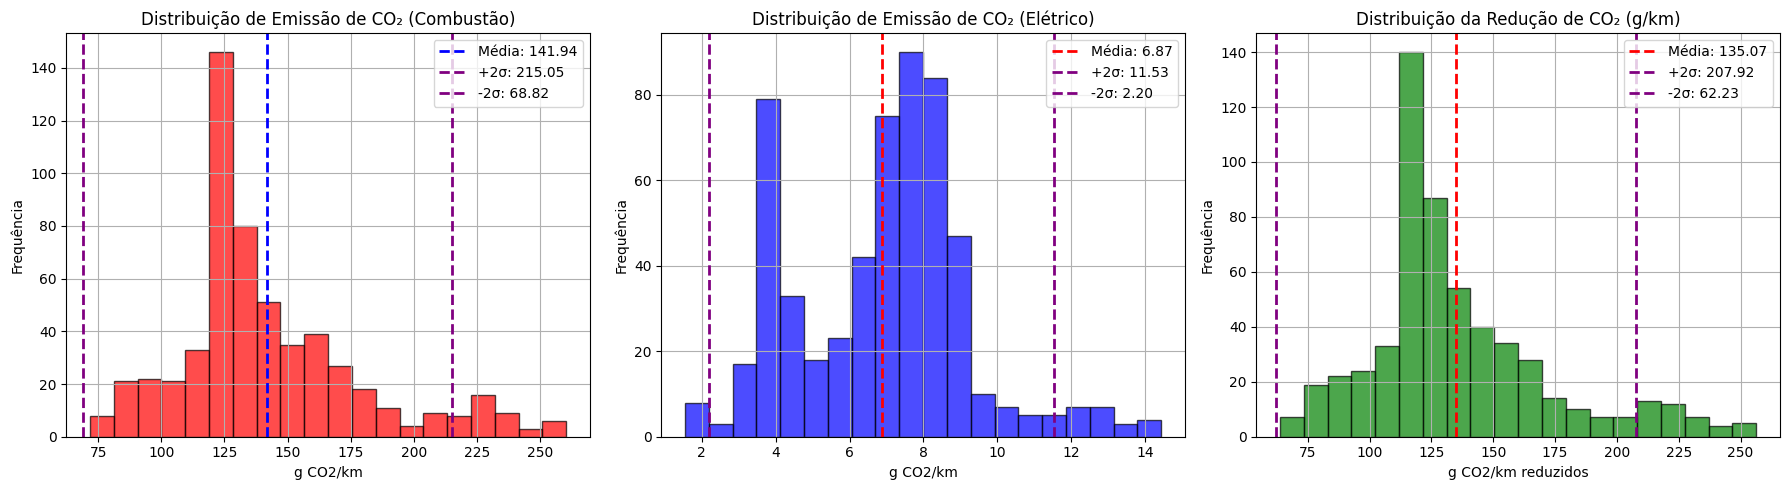

In [42]:
# Previsto para combust√£o desnormalizado
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist(y_pred_comb_inv[valid_idx], bins=20, color='red', alpha=0.7, edgecolor='black')
axes[0].axvline(media_comb, color='blue', linestyle='dashed', linewidth=2, label=f'M√©dia: {media_comb:.2f}')
axes[0].axvline(media_comb + 2 * desvio_comb, color='purple', linestyle='dashed', linewidth=2, label=f'+2œÉ: {(media_comb + 2 * desvio_comb):.2f}')
axes[0].axvline(media_comb - 2 * desvio_comb, color='purple', linestyle='dashed', linewidth=2, label=f'-2œÉ: {(media_comb - 2 * desvio_comb):.2f}')
axes[0].set_title("Distribui√ß√£o de Emiss√£o de CO‚ÇÇ (Combust√£o)")
axes[0].set_xlabel("g CO2/km")
axes[0].set_ylabel("Frequ√™ncia")
axes[0].grid()
axes[0].legend()

# Previsto para el√©trico desnormalizado
axes[1].hist(y_pred_elet_inv[valid_idx], bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[1].axvline(media_elet, color='red', linestyle='dashed', linewidth=2, label=f'M√©dia: {media_elet:.2f}')
axes[1].axvline(media_elet + 2 * desvio_elet, color='purple', linestyle='dashed', linewidth=2, label=f'+2œÉ: {(media_elet + 2 * desvio_elet):.2f}')
axes[1].axvline(media_elet - 2 * desvio_elet, color='purple', linestyle='dashed', linewidth=2, label=f'-2œÉ: {(media_elet - 2 * desvio_elet):.2f}')
axes[1].set_title("Distribui√ß√£o de Emiss√£o de CO‚ÇÇ (El√©trico)")
axes[1].set_xlabel("g CO2/km")
axes[1].set_ylabel("Frequ√™ncia")
axes[1].grid()
axes[1].legend()

# Histograma para redu√ß√£o absoluta
axes[2].hist(reducao_absoluta, bins=20, color='green', alpha=0.7, edgecolor='black')
axes[2].axvline(media_reducao_absoluta, color='red', linestyle='dashed', linewidth=2, label=f'M√©dia: {media_reducao_absoluta:.2f}')
axes[2].axvline(media_reducao_absoluta + 2 * desvio_reducao_absoluta, color='purple', linestyle='dashed', linewidth=2, label=f'+2œÉ: {(media_reducao_absoluta + 2 * desvio_reducao_absoluta):.2f}')
axes[2].axvline(media_reducao_absoluta - 2 * desvio_reducao_absoluta, color='purple', linestyle='dashed', linewidth=2, label=f'-2œÉ: {(media_reducao_absoluta - 2 * desvio_reducao_absoluta):.2f}')
axes[2].set_title("Distribui√ß√£o da Redu√ß√£o de CO‚ÇÇ (g/km)")
axes[2].set_xlabel("g CO2/km reduzidos")
axes[2].set_ylabel("Frequ√™ncia")
axes[2].grid()
axes[2].legend()

# Ajustar layout
plt.tight_layout()
plt.show()